# Media Salaries Distribution

This notebook performs some very basic analysis on the distribution of media salaries. The data was pulled from https://docs.google.com/spreadsheets/d/1SP3Sqqdv6R8chFamjtgdNlOrUar-hJXvkMSeha2mHQ8/edit#gid=0, described in https://www.cjr.org/cjr_outbox/google-doc-journalism-media-pay.php.

Scroll to the bottom to see results and conclusions. 

In [1]:
import numpy as np
import pandas as pd
import re
from typing import Callable, Iterator, Union, Optional, List
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib notebook
sns.set(palette=sns.color_palette("colorblind"))
plt.rcParams['figure.figsize'] = [20, 10]

In [2]:
df_raw = pd.read_csv("./real-media-salaries-20-06-13.csv", skiprows=3)

# Read Data into Pandas Dataframe

In [3]:
df_raw.head()

,TITLE,COMPANY,SALARY,Gender Identity / Ethnicity,YEARS OF EXPERIENCE,LOCATION,JOB DUTIES,PREV SALARIES/TITLES/ETC
0,Senior Reporter,(Broadcast media),"$125,000 + $6250 annual bonus",Asian cis female,9,New York,On-air original reporting and analysis; Writin...,"Broadcast media: $104,760 / Trade publication:..."
1,Bureau Chief,A B2B trade publication,"$58,000",Cis white female,12,Los Angeles,Run entire west coast bureau,NaN
2,Editor/Submission Manager,A biotech company,"$114,000",Female/white,6,"San Francisco, CA","Editing, project management, comment adjudication",NaN
3,Digital Editor,A Canadian magazine with international distrib...,"$42,000 CAD",Cis white male,7,Remote,"Oversee all publishing on website, social medi...",NaN
4,Associate Photo Editor,A Canadian Media Company,"$57,500",Male,16,Toronto,NaN,NaN


# Clean Titles, Salaries, and Years of Experience

In [4]:
df = df_raw[["TITLE", "SALARY", "YEARS OF EXPERIENCE"]]

In [5]:
def clean_title(title):
    if type(title) is str:
        title = title.lower()
    else:
        title = "unknown"
    if "editor" in title:
        return "editor"
    elif "reporter" in title:
        return "reporter"
    elif "manager" in title:
        return "manager"
    return title

In [6]:
df["clean_title"] = df["TITLE"].apply(clean_title)

<ipython-input-6-2032f20a1806>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["clean_title"] = df["TITLE"].apply(clean_title)


In [7]:
#df["YEARS OF EXPERIENCE"].unique()

In [8]:
def clean_yoe(yoe: Union[str, None]):
    # of course journos would write too much info in an float field
    # lazy match ints and dots from beginning, 
    if type(yoe) is str:
        com = re.compile("^[0-9.]*")
        res = com.match(yoe)
        if res and len(res.group(0)) > 0:
            return float(res.group(0))
        else:
            return -1
    else:
        # assume anything invalid here in invalid exp
        return -1

In [9]:
for yoe in df["YEARS OF EXPERIENCE"].unique():
    res = clean_yoe(yoe)
#    print(res)
#    print(type(res))


In [10]:
df["yoe"] = df["YEARS OF EXPERIENCE"].apply(clean_yoe)

<ipython-input-10-b275c1d922de>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["yoe"] = df["YEARS OF EXPERIENCE"].apply(clean_yoe)


In [11]:
df.head()

,TITLE,SALARY,YEARS OF EXPERIENCE,clean_title,yoe
0,Senior Reporter,"$125,000 + $6250 annual bonus",9,reporter,9.0
1,Bureau Chief,"$58,000",12,bureau chief,12.0
2,Editor/Submission Manager,"$114,000",6,editor,6.0
3,Digital Editor,"$42,000 CAD",7,editor,7.0
4,Associate Photo Editor,"$57,500",16,editor,16.0


In [12]:
#df["SALARY"].unique()

In [13]:
# exchange rates to dollar conversion
# taken on july 13th
EURO_USD = 1.13
CAD_USD = .74
AUD_USD = .69

In [14]:
def clean_salary(salary):
    # rules
    # if matching "euro" "CAD" "AUD" "USD" then use conversion factor 
    # if "hour" or "hr" found convert to yearly at 2087 hours (maybe incorrect)
    # if not using a non-usd currency, then find "$" token
    # if token exists, lazily read from it matching "," and up into "k"
    # if token does not exist, attempt to read the first numbers found
    if type(salary) is not str:
        return -1
    res = 0
    sal = salary.lower()
    spot_rate = 1 
    if "usd" in sal:
        pass
    elif "euro" in sal:
        spot_rate = EURO_USD
    elif "cad" in sal:
        spot_rate = CAD_USD
    elif "aud" in sal:
        spot_rate = AUD_USD
    
    yearly_conversion = False
    if "hour" in sal or "hr" in sal:
        yearly_conversion = True
        
    com = re.compile(r"\$?([0-9,]*)?k?")
    m = com.match(sal)
    if m and len(m.group(0)) > 0:
        res = m.group(0)
        # this really should be some lookbehind but I'm lazy
        if "$" in res:
            res = res[1:]
        res = res.replace(",", "")
        multi = 1
        if "k" in res:
            res = res.replace("k", "")
            multi = 1000
        if len(res) == 0:
            return -1
        res = float(res)*multi
    else:
        return -1
    if yearly_conversion and res*2087 < 500000:
        res = res*2087
    
    return res*spot_rate

In [15]:
for s in df["SALARY"].unique():
    r = clean_salary(s)
  #  print(r)

In [16]:
df["sal"] = df["SALARY"].apply(clean_salary)

<ipython-input-16-4b4a5e86785e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sal"] = df["SALARY"].apply(clean_salary)


In [17]:
df.head()

,TITLE,SALARY,YEARS OF EXPERIENCE,clean_title,yoe,sal
0,Senior Reporter,"$125,000 + $6250 annual bonus",9,reporter,9.0,125000.0
1,Bureau Chief,"$58,000",12,bureau chief,12.0,58000.0
2,Editor/Submission Manager,"$114,000",6,editor,6.0,114000.0
3,Digital Editor,"$42,000 CAD",7,editor,7.0,31080.0
4,Associate Photo Editor,"$57,500",16,editor,16.0,57500.0


In [18]:
#df["sal"].unique()

In [19]:
# filter out invalid values and filter out some outliers
clean_df = df.query('yoe != -1 & yoe >= 0 & sal != -1  & sal < 300000 & sal > 10000')
clean_df.sal.describe()

count      1647.000000
mean      65350.168427
std       29882.841775
min       10435.000000
25%       45000.000000
50%       60000.000000
75%       78550.000000
max      250000.000000
Name: sal, dtype: float64

In [20]:
bins = np.linspace(clean_df.sal.min(), clean_df.sal.max(), 20)
bins

array([ 10435.        ,  23043.68421053,  35652.36842105,  48261.05263158,
        60869.73684211,  73478.42105263,  86087.10526316,  98695.78947368,
       111304.47368421, 123913.15789474, 136521.84210526, 149130.52631579,
       161739.21052632, 174347.89473684, 186956.57894737, 199565.26315789,
       212173.94736842, 224782.63157895, 237391.31578947, 250000.        ])

# Results

## Visualize the Distribution Across *All* Datapoints

<IPython.core.display.Javascript object>


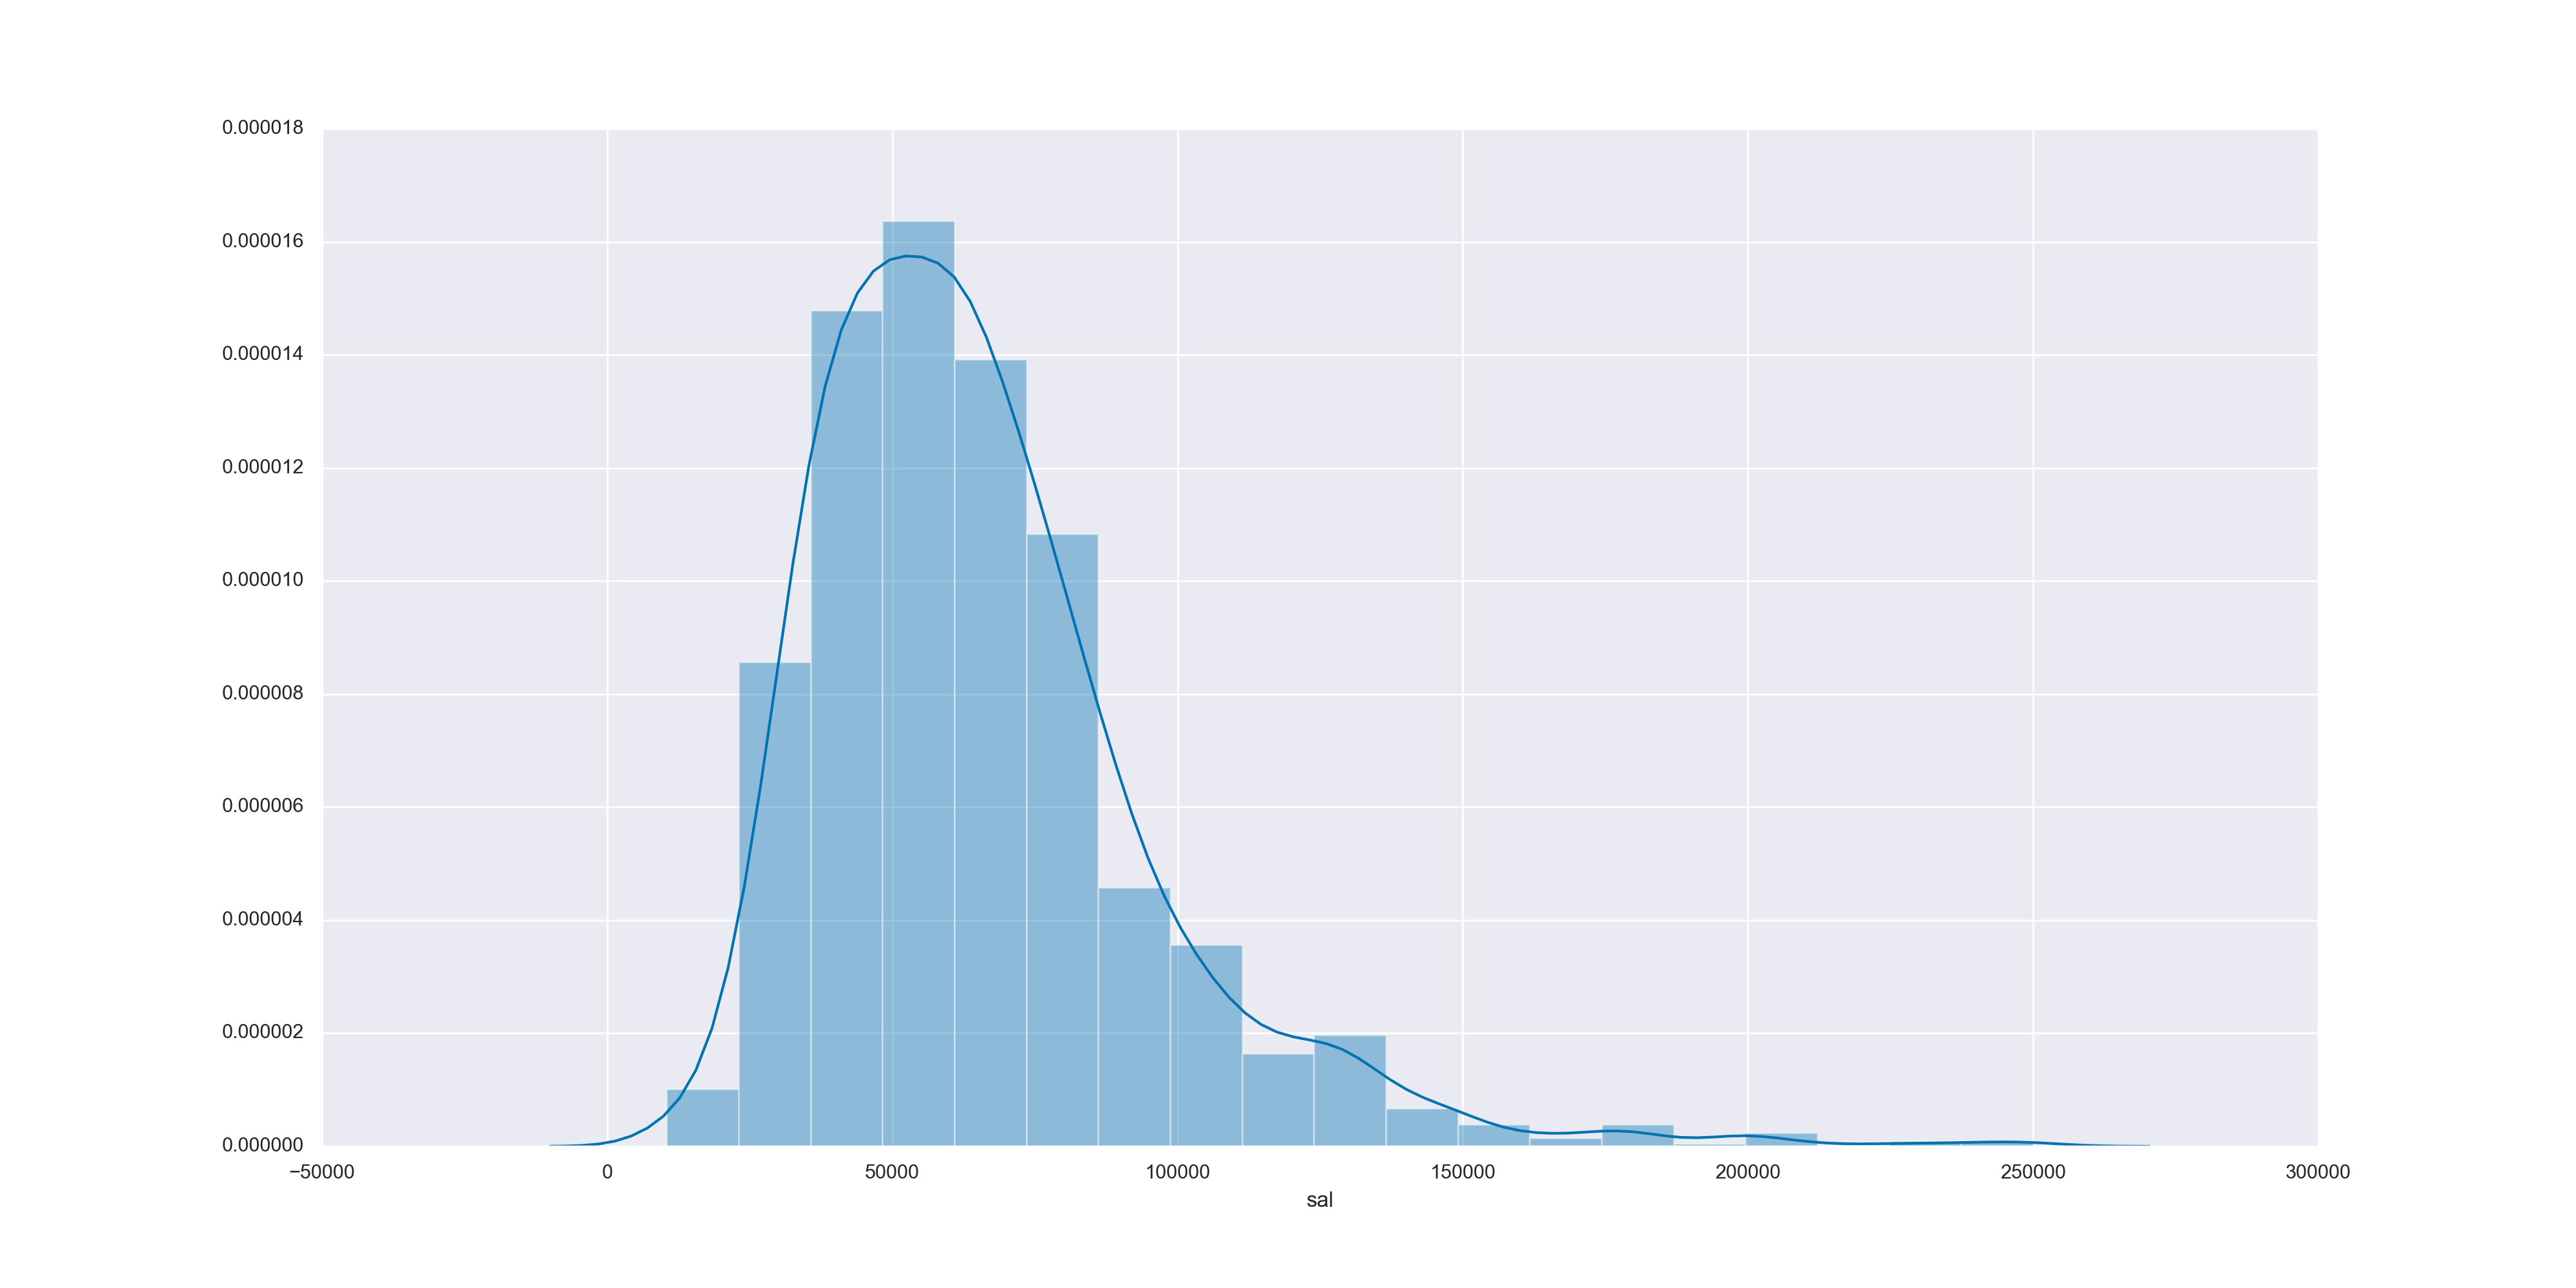

In [21]:
# overall distribution
ax = sns.distplot(clean_df["sal"], bins=bins)

Overall, it seems like journalist salaries compare nicely to the expected normal distribution. However, to further analysis is needed to control for years of experience. 

## Joint Plot and Years of Experience

<IPython.core.display.Javascript object>


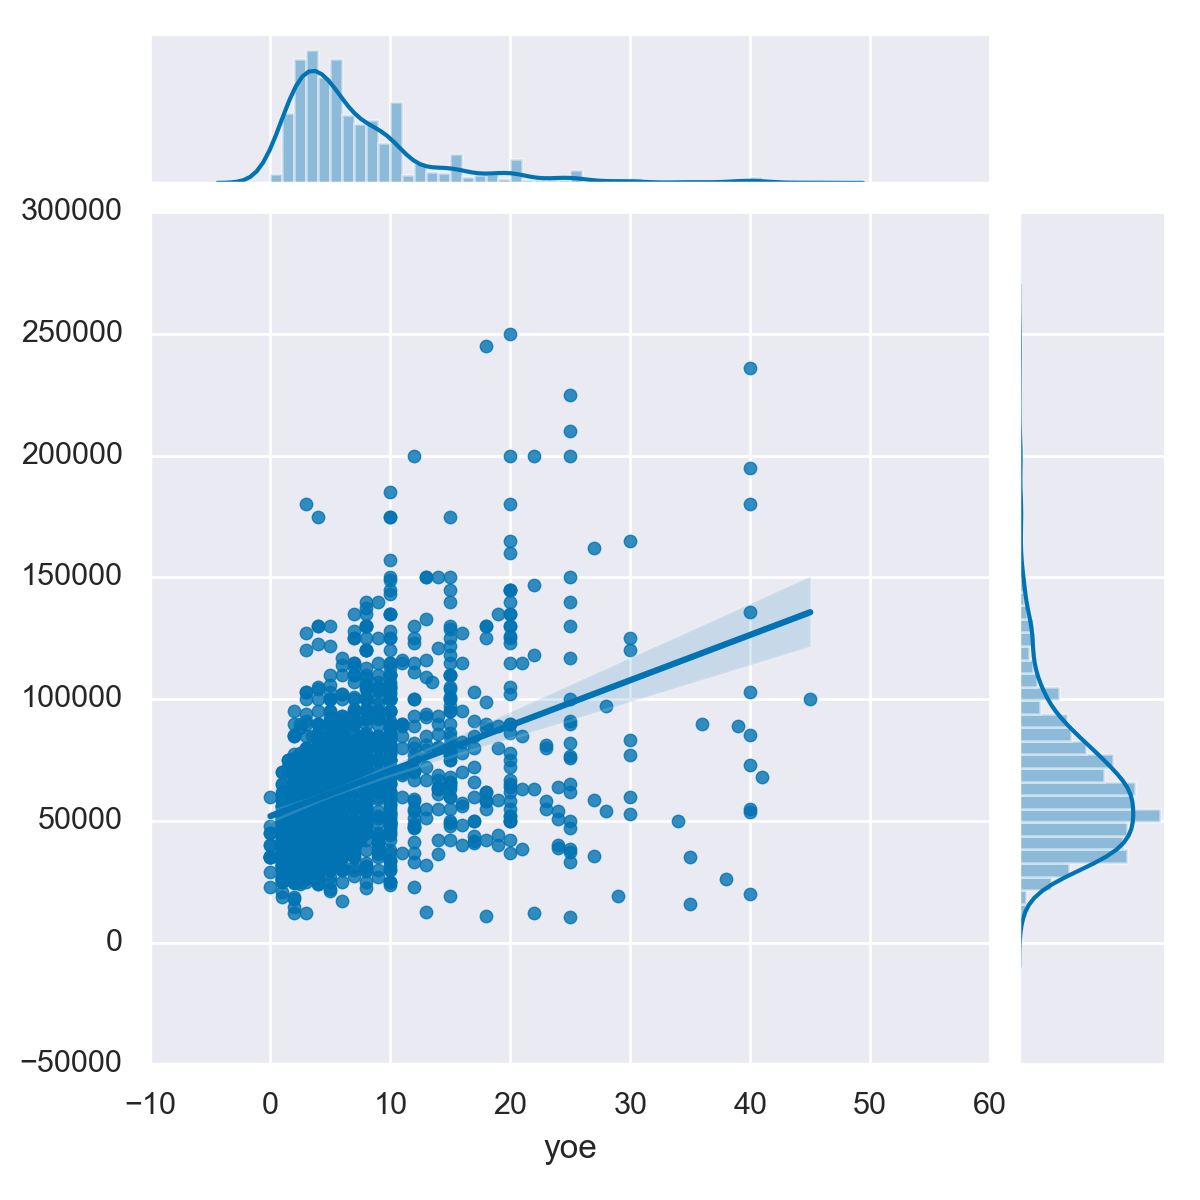

In [22]:
# jointplot of yoe and salary

ax = sns.jointplot(x="yoe", y="sal", data=clean_df, kind="reg")

A basic regression points out that there exists "some" correlation between years of experience and salary during the early years, but this levels off the years of experience increases.

It's also very likely that some of the outliers at higher ranges are poor dataset or ETL issues. Since the regression itself is not that useful, we can take a look at residuals. 

<IPython.core.display.Javascript object>


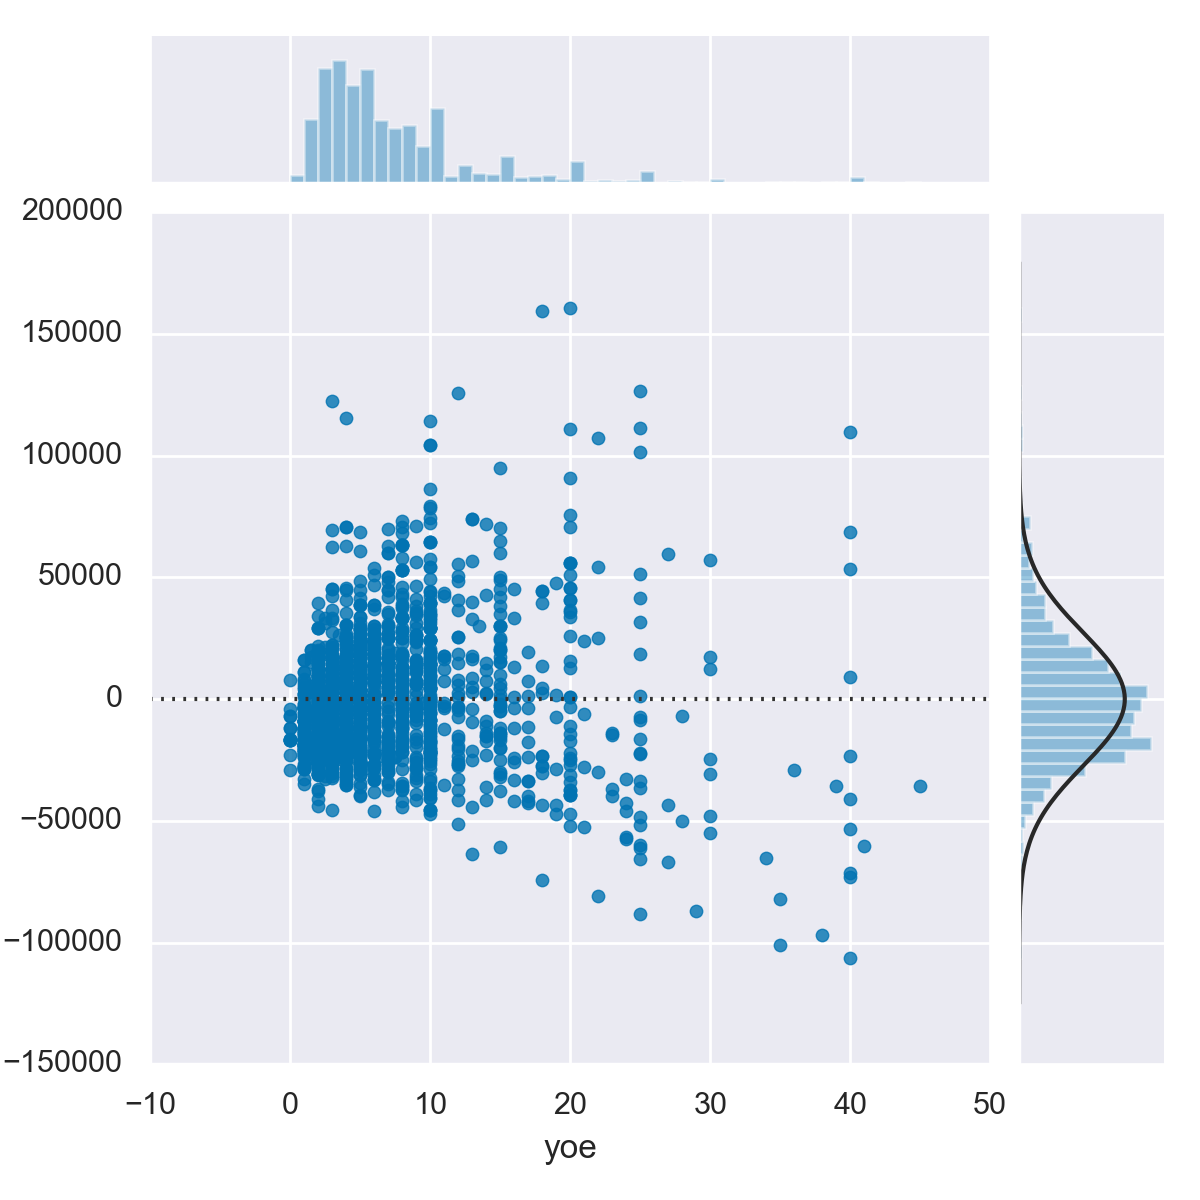

In [23]:

ax = sns.jointplot(x="yoe", y="sal", data=clean_df, kind="resid")

This shows that the predictive value of the regression lessons as years of experience increase, especially past ~15 years of experience.

# Conclusion

In conclusion, media salaries seem largely normally distributed, as most seem to cluster around somewhere between the 70-100k range between the first 10 years. 

However, interestingly enough, it seems that there is largely a "cap" on media salaries past 15 years. The data stops correlating, and largely loses its predictive value. This probably represents the "peak" earnings of a specific type of media job (journalist, associate, etc) that can be reached without pushing into management territory. 